In [2]:
import os
import pandas as pd
import numpy as np
import scipy.stats as st
from sklearn.metrics.pairwise import pairwise_distances
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors

## Input data

In [3]:
celltype = "IGH_HUMAN"
myfiles = [x for x in os.listdir(".") if x.startswith('cdr3-clones') and celltype in x]
myfiles

['cdr3-clones-BASTA_study-IGH_HUMAN-after-reassignment.csv',
 'cdr3-clones-Behcet-IGH_HUMAN-after-reassignment.csv',
 'cdr3-clones-BMC-IGH_HUMAN-after-reassignment.csv',
 'cdr3-clones-Canomad-IGH_HUMAN-after-reassignment.csv',
 'cdr3-clones-DOMINO-IGH_HUMAN-after-reassignment.csv',
 'cdr3-clones-Paired_rerun-IGH_HUMAN-after-reassignment.csv']

In [4]:
pt_file="20180604_Run029_pt-table.csv"
run = "run29"
plotfile=run + "-similarity-" + celltype + '.pdf'
suspects_list = run + "-similarity-" + celltype + ".txt"

## Import clonesdata

In [5]:
clones = pd.read_csv(myfiles[0], sep="\t")
if len(myfiles) > 1:
    for clones_file in myfiles[1:]:
        clones = pd.concat([clones, pd.read_csv(clones_file, sep="\t")])

In [6]:
clones.head()

,Sample,MID,cdr3pep,freq,uniq_umis,V_sub,J_sub,sum_sites,avg_sites,read_perc,umi_perc
0,BASTA01_S150,ACGTACGT,CAKLVVIPDYWGQGTLVT,1426,1366,IGHV3-23,IGHJ4,38,0.026648,2.648441,2.607766
1,BASTA01_S150,ACGTACGT,CASGQNFVSGFDYWGQGTLVT,1338,1279,IGHV5-51,IGHJ4,29,0.021674,2.485003,2.441678
2,BASTA01_S150,ACGTACGT,CAGDTSGSFDYWGQGTLVT,720,692,IGHV3-30,IGHJ4,10,0.013889,1.337221,1.321064
3,BASTA01_S150,ACGTACGT,CAKDFNWDEGYWGQGTLVT,234,229,IGHV3-23,"IGHJ4,IGHJ5",3,0.012821,0.434597,0.437173
4,BASTA01_S150,ACGTACGT,CTRTFLSAAIKDYFDYWGQGTLVT,197,188,IGHV2-70,IGHJ4,15,0.076142,0.365879,0.358902


In [7]:
# Summarize data on CDR3
clones = clones.groupby(by=['Sample','cdr3pep']).sum()
clones = clones.reset_index()
clones = clones.sort_values(['Sample','freq'], ascending=False)
clones.head()

,Sample,cdr3pep,freq,uniq_umis,sum_sites,avg_sites,read_perc,umi_perc
1868452,PS-15-BR2_S235,CARAHYGVNAFDIWGQGTMVT,2918,424,21,0.007197,19.706895,12.365121
1868269,PS-15-BR2_S235,CAKCTRPGYSSGWCNWLDPWGQGTLVT,1552,261,36,0.023196,10.481529,7.611549
1869064,PS-15-BR2_S235,CARVSSSSWYAHFDYWGQGTLVT,956,155,4,0.004184,6.456406,4.520268
1868387,PS-15-BR2_S235,CAKVFDCGGDCYPEYFQHWGQGTLVT,482,92,8,0.016598,3.255217,2.682998
1868708,PS-15-BR2_S235,CARERASYYGSGSRGTLKSWGQGTLVT,472,178,15,0.031780,3.187682,5.191018


## Import patient table

In [8]:
pt = pd.read_csv(pt_file, sep="\t")
pt = pt.rename(columns = {'Sample': 'SampleInfo'})
pt.head()

,Samples order,Sample_ID,Sample name,MID,Project,Species,Chain,Patient,SampleInfo,UMI
0,S1,N701_S502,BMC110-1-BuH,NaN,BMC,human,BCRh,BMC110,V1,yes
1,S2,N702_S502,BMC110-2-BuH,NaN,BMC,human,BCRh,BMC110,V2,yes
2,S3,N703_S502,BMC111-1-BuH,NaN,BMC,human,BCRh,BMC111,V1,yes
3,S4,N704_S502,BMC111-2-BuH,NaN,BMC,human,BCRh,BMC111,V2,yes
4,S5,N705_S502,BMC116-1-BuH,NaN,BMC,human,BCRh,BMC116,V1,yes


In [9]:
# Concatenate sample-id and nr in a new column
f = lambda x,y: str(x) + "_" + str(y)
pt['Sample'] = [name for name in map(f, pt['Sample name'], pt['Samples order'])]
pt = pt[["Sample","Patient"]]

In [10]:
pt.head()

,Sample,Patient
0,BMC110-1-BuH_S1,BMC110
1,BMC110-2-BuH_S2,BMC110
2,BMC111-1-BuH_S3,BMC111
3,BMC111-2-BuH_S4,BMC111
4,BMC116-1-BuH_S5,BMC116


## Merge clones with pt

In [11]:
# Join data frames
df = pd.merge(clones, pt, how='inner', on = 'Sample')
df.head()

,Sample,cdr3pep,freq,uniq_umis,sum_sites,avg_sites,read_perc,umi_perc,Patient
0,PS-15-BR2_S235,CARAHYGVNAFDIWGQGTMVT,2918,424,21,0.007197,19.706895,12.365121,BP0165
1,PS-15-BR2_S235,CAKCTRPGYSSGWCNWLDPWGQGTLVT,1552,261,36,0.023196,10.481529,7.611549,BP0165
2,PS-15-BR2_S235,CARVSSSSWYAHFDYWGQGTLVT,956,155,4,0.004184,6.456406,4.520268,BP0165
3,PS-15-BR2_S235,CAKVFDCGGDCYPEYFQHWGQGTLVT,482,92,8,0.016598,3.255217,2.682998,BP0165
4,PS-15-BR2_S235,CARERASYYGSGSRGTLKSWGQGTLVT,472,178,15,0.031780,3.187682,5.191018,BP0165


## Determine distance between samples

In [12]:
df_pivot = df.pivot_table(columns=['Patient','Sample'], index='cdr3pep', values='freq')
df_pivot = df_pivot.fillna(0)
df_pivot.head()

Patient                      B001       B002       B003       B004       B005  \
Sample                 B001-B_S83 B002-B_S84 B003-B_S85 B004-B_S86 B005-B_S87   
cdr3pep                                                                         
AAAELSDAFDIWGQGTMVT           0.0        0.0        0.0        0.0        0.0   
AAAGGDYYYYYMDVWGKGTTVT        0.0        0.0        0.0        0.0        0.0   
AAAGGDYYYYYMDVWGKRTTVT        0.0        0.0        0.0        0.0        0.0   
AAAGTGTLFDYWGQGTLVT           0.0        0.0        0.0        0.0        0.0   
AAAGTTLLLYWGQGTLVT            0.0        0.0        0.0        0.0        0.0   

Patient                      B006       B007       B008        B009  \
Sample                 B006-B_S88 B007-B_S89 B008-B_S90 B009-B_S107   
cdr3pep                                                               
AAAELSDAFDIWGQGTMVT           0.0        0.0        0.0         0.0   
AAAGGDYYYYYMDVWGKGTTVT        0.0        0.0        0.0         0.0   
AAAGGDYYYYYMDVWGKRTTVT        0.0        0.0        0.0         0.0   
AAAGTGTLFDYWGQGTLVT           0.0        0.0        0.0         0.0   
AAAGTTLLLYWGQGTLVT            0.0        0.0        0.0         0.0   

Patient                                     ...               SS3  \
Sample                 BMC210-1-BuH_S91     ...      BASTA11_S176   
cdr3pep                                     ...                     
AAAELSDAFDIWGQGTMVT                 0.0     ...               0.0   
AAAGGDYYYYYMDVWGKGTTVT              0.0     ...               0.0   
AAAGGDYYYYYMDVWGKRTTVT              0.0     ...               0.0   
AAAGTGTLFDYWGQGTLVT                 0.0     ...               0.0   
AAAGTTLLLYWGQGTLVT                  0.0     ...               0.0   

Patient                                                                     \
Sample                 BASTA12_S177 BASTA13_S178 BASTA14_S179 BASTA15_S180   
cdr3pep                                                                      
AAAELSDAFDIWGQGTMVT             0.0          0.0          0.0          0.0   
AAAGGDYYYYYMDVWGKGTTVT          0.0          0.0          0.0          0.0   
AAAGGDYYYYYMDVWGKRTTVT          0.0          0.0          0.0          0.0   
AAAGTGTLFDYWGQGTLVT             0.0          0.0          0.0          0.0   
AAAGTTLLLYWGQGTLVT              0.0          0.0          0.0          0.0   

Patient                         SS4                                         \
Sample                 BASTA16_S181 BASTA17_S198 BASTA18_S199 BASTA19_S200   
cdr3pep                                                                      
AAAELSDAFDIWGQGTMVT             0.0          0.0          0.0          0.0   
AAAGGDYYYYYMDVWGKGTTVT          0.0          0.0          0.0          0.0   
AAAGGDYYYYYMDVWGKRTTVT          0.0          0.0          0.0          0.0   
AAAGTGTLFDYWGQGTLVT             0.0          0.0          0.0          0.0   
AAAGTTLLLYWGQGTLVT              0.0          0.0          0.0          0.0   

Patient                              
Sample                 BASTA20_S201  
cdr3pep                              
AAAELSDAFDIWGQGTMVT             0.0  
AAAGGDYYYYYMDVWGKGTTVT          0.0  
AAAGGDYYYYYMDVWGKRTTVT          0.0  
AAAGTGTLFDYWGQGTLVT             0.0  
AAAGTTLLLYWGQGTLVT              0.0  

[5 rows x 126 columns]

In [13]:
sim = 1 - pairwise_distances(df_pivot.T, metric = "braycurtis")
sim = pd.DataFrame(sim, index=df_pivot.columns, columns=df_pivot.columns)
sim.head()

Patient                  B001       B002       B003       B004       B005  \
Sample             B001-B_S83 B002-B_S84 B003-B_S85 B004-B_S86 B005-B_S87   
Patient Sample                                                              
B001    B001-B_S83   1.000000   0.000212   0.000291   0.000301   0.000000   
B002    B002-B_S84   0.000212   1.000000   0.000115   0.000266   0.000072   
B003    B003-B_S85   0.000291   0.000115   1.000000   0.000093   0.000141   
B004    B004-B_S86   0.000301   0.000266   0.000093   1.000000   0.000000   
B005    B005-B_S87   0.000000   0.000072   0.000141   0.000000   1.000000   

Patient                  B006       B007       B008        B009  \
Sample             B006-B_S88 B007-B_S89 B008-B_S90 B009-B_S107   
Patient Sample                                                    
B001    B001-B_S83   0.000000   0.000369   0.000192    0.000783   
B002    B002-B_S84   0.000029   0.000299   0.000204    0.000383   
B003    B003-B_S85   0.000208   0.000263   0.000302    0.000146   
B004    B004-B_S86   0.000058   0.000633   0.000310    0.000238   
B005    B005-B_S87   0.000037   0.000124   0.000049    0.000179   

Patient                                 ...               SS3               \
Sample             BMC210-1-BuH_S91     ...      BASTA11_S176 BASTA12_S177   
Patient Sample                          ...                                  
B001    B001-B_S83         0.000115     ...          0.000174     0.000000   
B002    B002-B_S84         0.000436     ...          0.000311     0.000000   
B003    B003-B_S85         0.000276     ...          0.000260     0.000000   
B004    B004-B_S86         0.000244     ...          0.000210     0.000039   
B005    B005-B_S87         0.000185     ...          0.000124     0.000000   

Patient                                                            SS4  \
Sample             BASTA13_S178 BASTA14_S179 BASTA15_S180 BASTA16_S181   
Patient Sample                                                           
B001    B001-B_S83     0.000000     0.000000     0.000118     0.000155   
B002    B002-B_S84     0.000037     0.000000     0.000283     0.000063   
B003    B003-B_S85     0.000048     0.000046     0.000277     0.000193   
B004    B004-B_S86     0.000038     0.000000     0.000402     0.000214   
B005    B005-B_S87     0.000106     0.000000     0.000089     0.000076   

Patient                                                                 
Sample             BASTA17_S198 BASTA18_S199 BASTA19_S200 BASTA20_S201  
Patient Sample                                                          
B001    B001-B_S83     0.000100     0.000295          0.0     0.000295  
B002    B002-B_S84     0.000047     0.000263          0.0     0.000336  
B003    B003-B_S85     0.000055     0.000064          0.0     0.000396  
B004    B004-B_S86     0.000024     0.000267          0.0     0.000466  
B005    B005-B_S87     0.000087     0.000110          0.0     0.000227  

[5 rows x 126 columns]

## Create a heatmap

In [14]:
def drawBox(end, length):
    '''
    Description: draw a square with lines
    In: start (int), length (int)
    Out: None, 4 lines will be drawn on the canvas
    '''
    linewidth = 5
    low = end - length
    high = end
    plt.plot([low, high], [high, high], 'k-', lw=linewidth)   # N
    plt.plot([high, high], [low, high], 'k-', lw=linewidth)   # E
    plt.plot([low, high], [low, low], 'k-', lw=linewidth)     # S
    plt.plot([low, low], [low, high], 'k-', lw=linewidth)     # W

In [15]:
def drawHeatmap(overlap):
    font = {'family' : 'sans-serif',
            'weight' : 'normal',
            'size'   : 22}

    matplotlib.rc('font', **font)

    fig, ax = plt.subplots(figsize=(60, 60))
    fig.subplots_adjust(bottom=0.3)

    # is used for log scaling
    Z1 = overlap.values
    Z1[Z1 <= 0] = Z1[Z1 > 0].min()  # Replace any value below or equal to zero with lowest value above zero
    
    print("min value:", Z1.min())
    print("max value:", Z1.max())

    # get the patient-id
    labels_x = [x[0] for x in overlap.index]
    labels_y = [y[0] for y in overlap.columns]

    # draw heatmap
    plt.pcolor(overlap.values, cmap=plt.cm.viridis, norm=colors.LogNorm(vmin=Z1.min(), vmax=Z1.max()))
    #plt.pcolor(overlap.values, cmap=plt.cm.viridis)
    plt.colorbar()
    plt.yticks(np.arange(0.5, len(overlap.index), 1), overlap.columns, rotation=0)
    plt.xticks(np.arange(0.5, len(overlap.columns), 1), overlap.index, rotation=90)

    # Add lines around same patient-id
    prev_label = None
    length = 0
    for i in range(len(labels_x)):
        if prev_label is not None and prev_label != labels_x[i]:
            drawBox(i, length)
            length = 0
        prev_label = labels_x[i]
        length +=1
    i += 1
    drawBox(i, length)

    # Save figure to file
    fig.savefig(plotfile)
    print("Wrote", plotfile, "to disk")

min value: 1.4514736085824431e-05
max value: 1.0
Wrote run29-similarity-IGH_HUMAN.pdf to disk


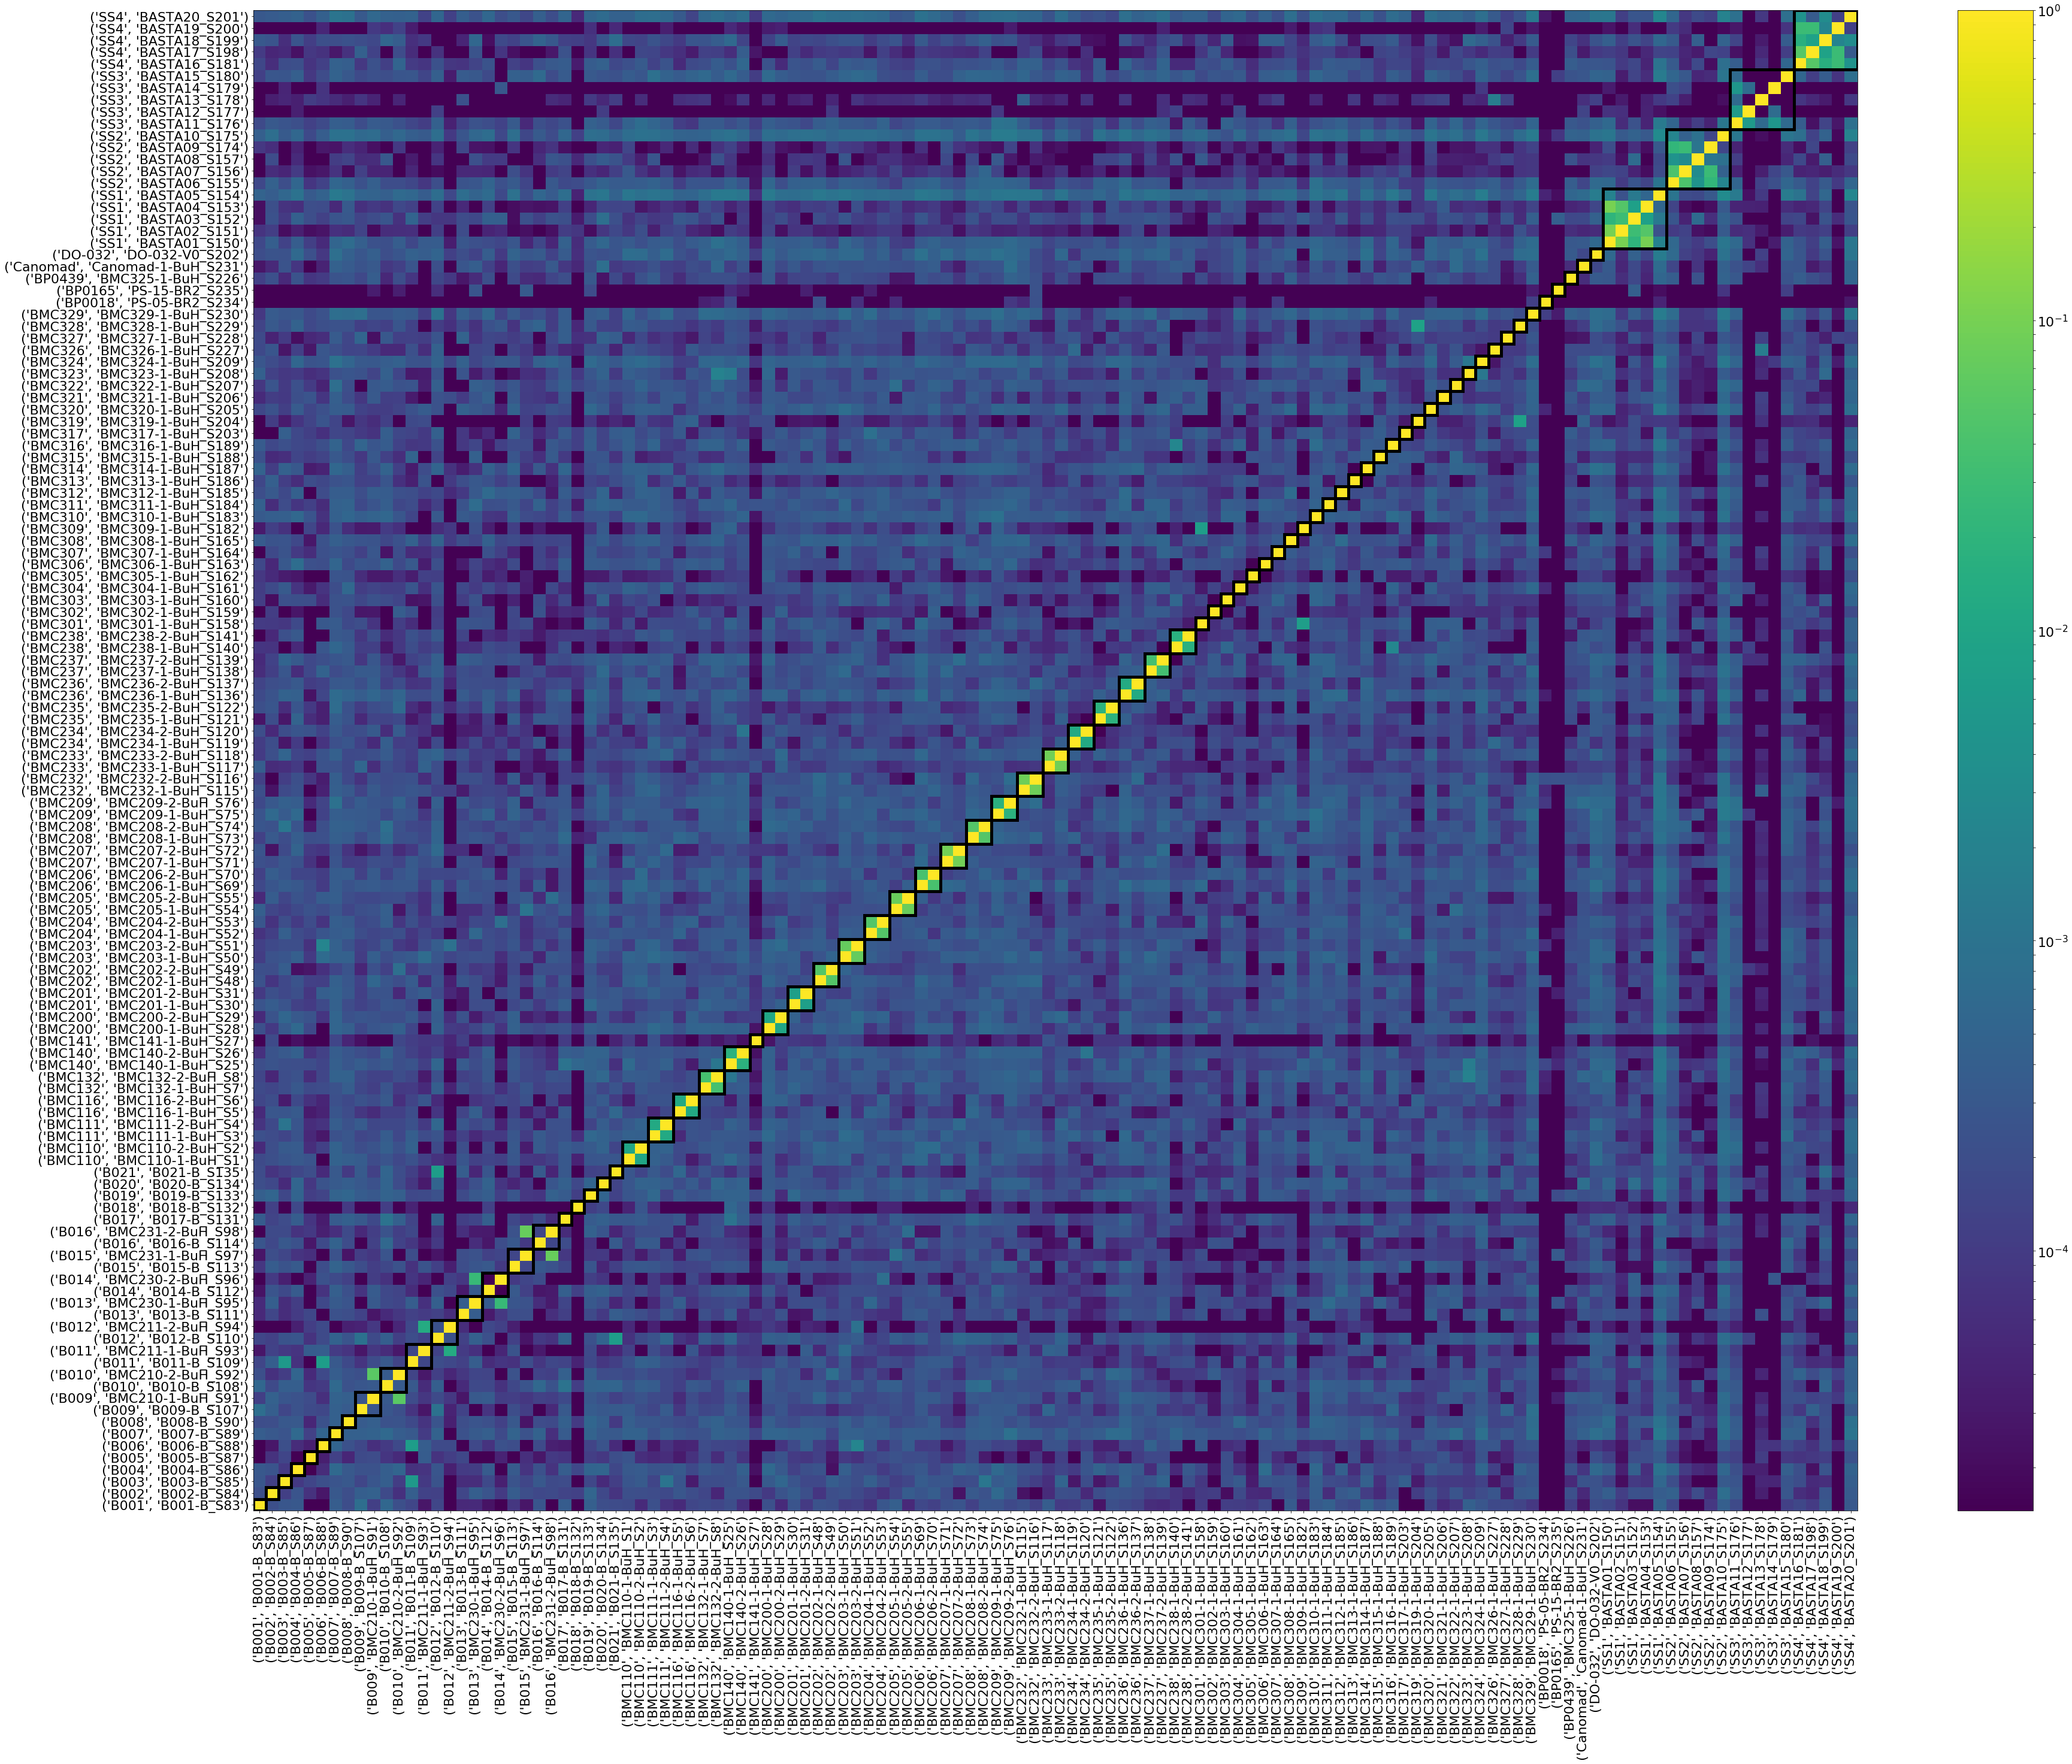

In [16]:
drawHeatmap(sim)

## Highlight anomalies

In [17]:
# get index pairs of same patient (divide same vs not same sample) and list indices for different patients
same_sample = list()
same_patient = list()
diff_patient = list()
for x in sim.index:
    for y in sim.columns:
        if x[0] == y[0]:  # same patient
            if x[1] == y[1]:  # same sample
                same_sample.append((x, y))
            else:        # same patient, but not same sample
                same_patient.append((x, y))
        else:             # not same patient
            diff_patient.append((x,y))                    

In [18]:
# Get values of same patient (but different samples) and values for different patients
values_same_patient = [sim.loc[x][y] for x,y in same_patient]
values_diff_patient = [sim.loc[x][y] for x,y in diff_patient]
mean_diff_patient = np.mean(values_diff_patient)
std_diff_patient = np.std(values_diff_patient)
threshold = mean_diff_patient + 4 * std_diff_patient
print("mean same patient", np.mean(values_same_patient), np.std(values_same_patient))
print("mean diff patient", mean_diff_patient, std_diff_patient)
print("threshold", threshold)

mean same patient 0.020169436707850326 0.027631719419696388
mean diff patient 0.0002379028646142669 0.0011427478526321545
threshold 0.004808894275142885


In [19]:
a, b = st.t.interval(0.95, len(values_diff_patient)-1, loc=np.mean(values_diff_patient), scale=st.sem(values_diff_patient))
print(a,b)

0.0002199743362665771 0.0002558313929619567


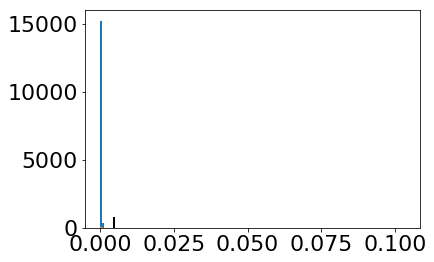

In [20]:
# Boxplot
plt.hist(values_diff_patient, bins=100)
plt.hist(values_same_patient, bins=100)
plt.plot([threshold, threshold], [0, 750], 'k-', lw=2)

In [21]:
# Print sample names if similarity is twice the 95% interval
fhOut = open(suspects_list, "w")
check_samples = list()
for i,j in diff_patient:
    if sim.loc[i][j] > threshold:
        print(i, j, sim.loc[i][j])
        print(i, j, sim.loc[i][j], file=fhOut)
        check_samples.append((i,j))
fhOut.close()

('B003', 'B003-B_S85') ('B011', 'B011-B_S109') 0.0058032987171655614
('B006', 'B006-B_S88') ('B011', 'B011-B_S109') 0.006770037126010098
('B009', 'BMC210-1-BuH_S91') ('B010', 'BMC210-2-BuH_S92') 0.05835413912958343
('B010', 'BMC210-2-BuH_S92') ('B009', 'BMC210-1-BuH_S91') 0.05835413912958343
('B011', 'B011-B_S109') ('B003', 'B003-B_S85') 0.0058032987171655614
('B011', 'B011-B_S109') ('B006', 'B006-B_S88') 0.006770037126010098
('B011', 'BMC211-1-BuH_S93') ('B012', 'BMC211-2-BuH_S94') 0.013223457263319305
('B012', 'B012-B_S110') ('B021', 'B021-B_S135') 0.006773986335234516
('B012', 'BMC211-2-BuH_S94') ('B011', 'BMC211-1-BuH_S93') 0.013223457263319305
('B013', 'BMC230-1-BuH_S95') ('B014', 'BMC230-2-BuH_S96') 0.02604646874423755
('B014', 'BMC230-2-BuH_S96') ('B013', 'BMC230-1-BuH_S95') 0.02604646874423755
('B015', 'BMC231-1-BuH_S97') ('B016', 'BMC231-2-BuH_S98') 0.07376235123806962
('B016', 'BMC231-2-BuH_S98') ('B015', 'BMC231-1-BuH_S97') 0.07376235123806962
('B021', 'B021-B_S135') ('B012'

In [22]:
sim2 = sim.copy()
for i, j in check_samples:
    sim2.loc[i][j] = 1

min value: 1.4514736085824431e-05
max value: 1.0
Wrote run29-similarity-IGH_HUMAN-2.pdf to disk


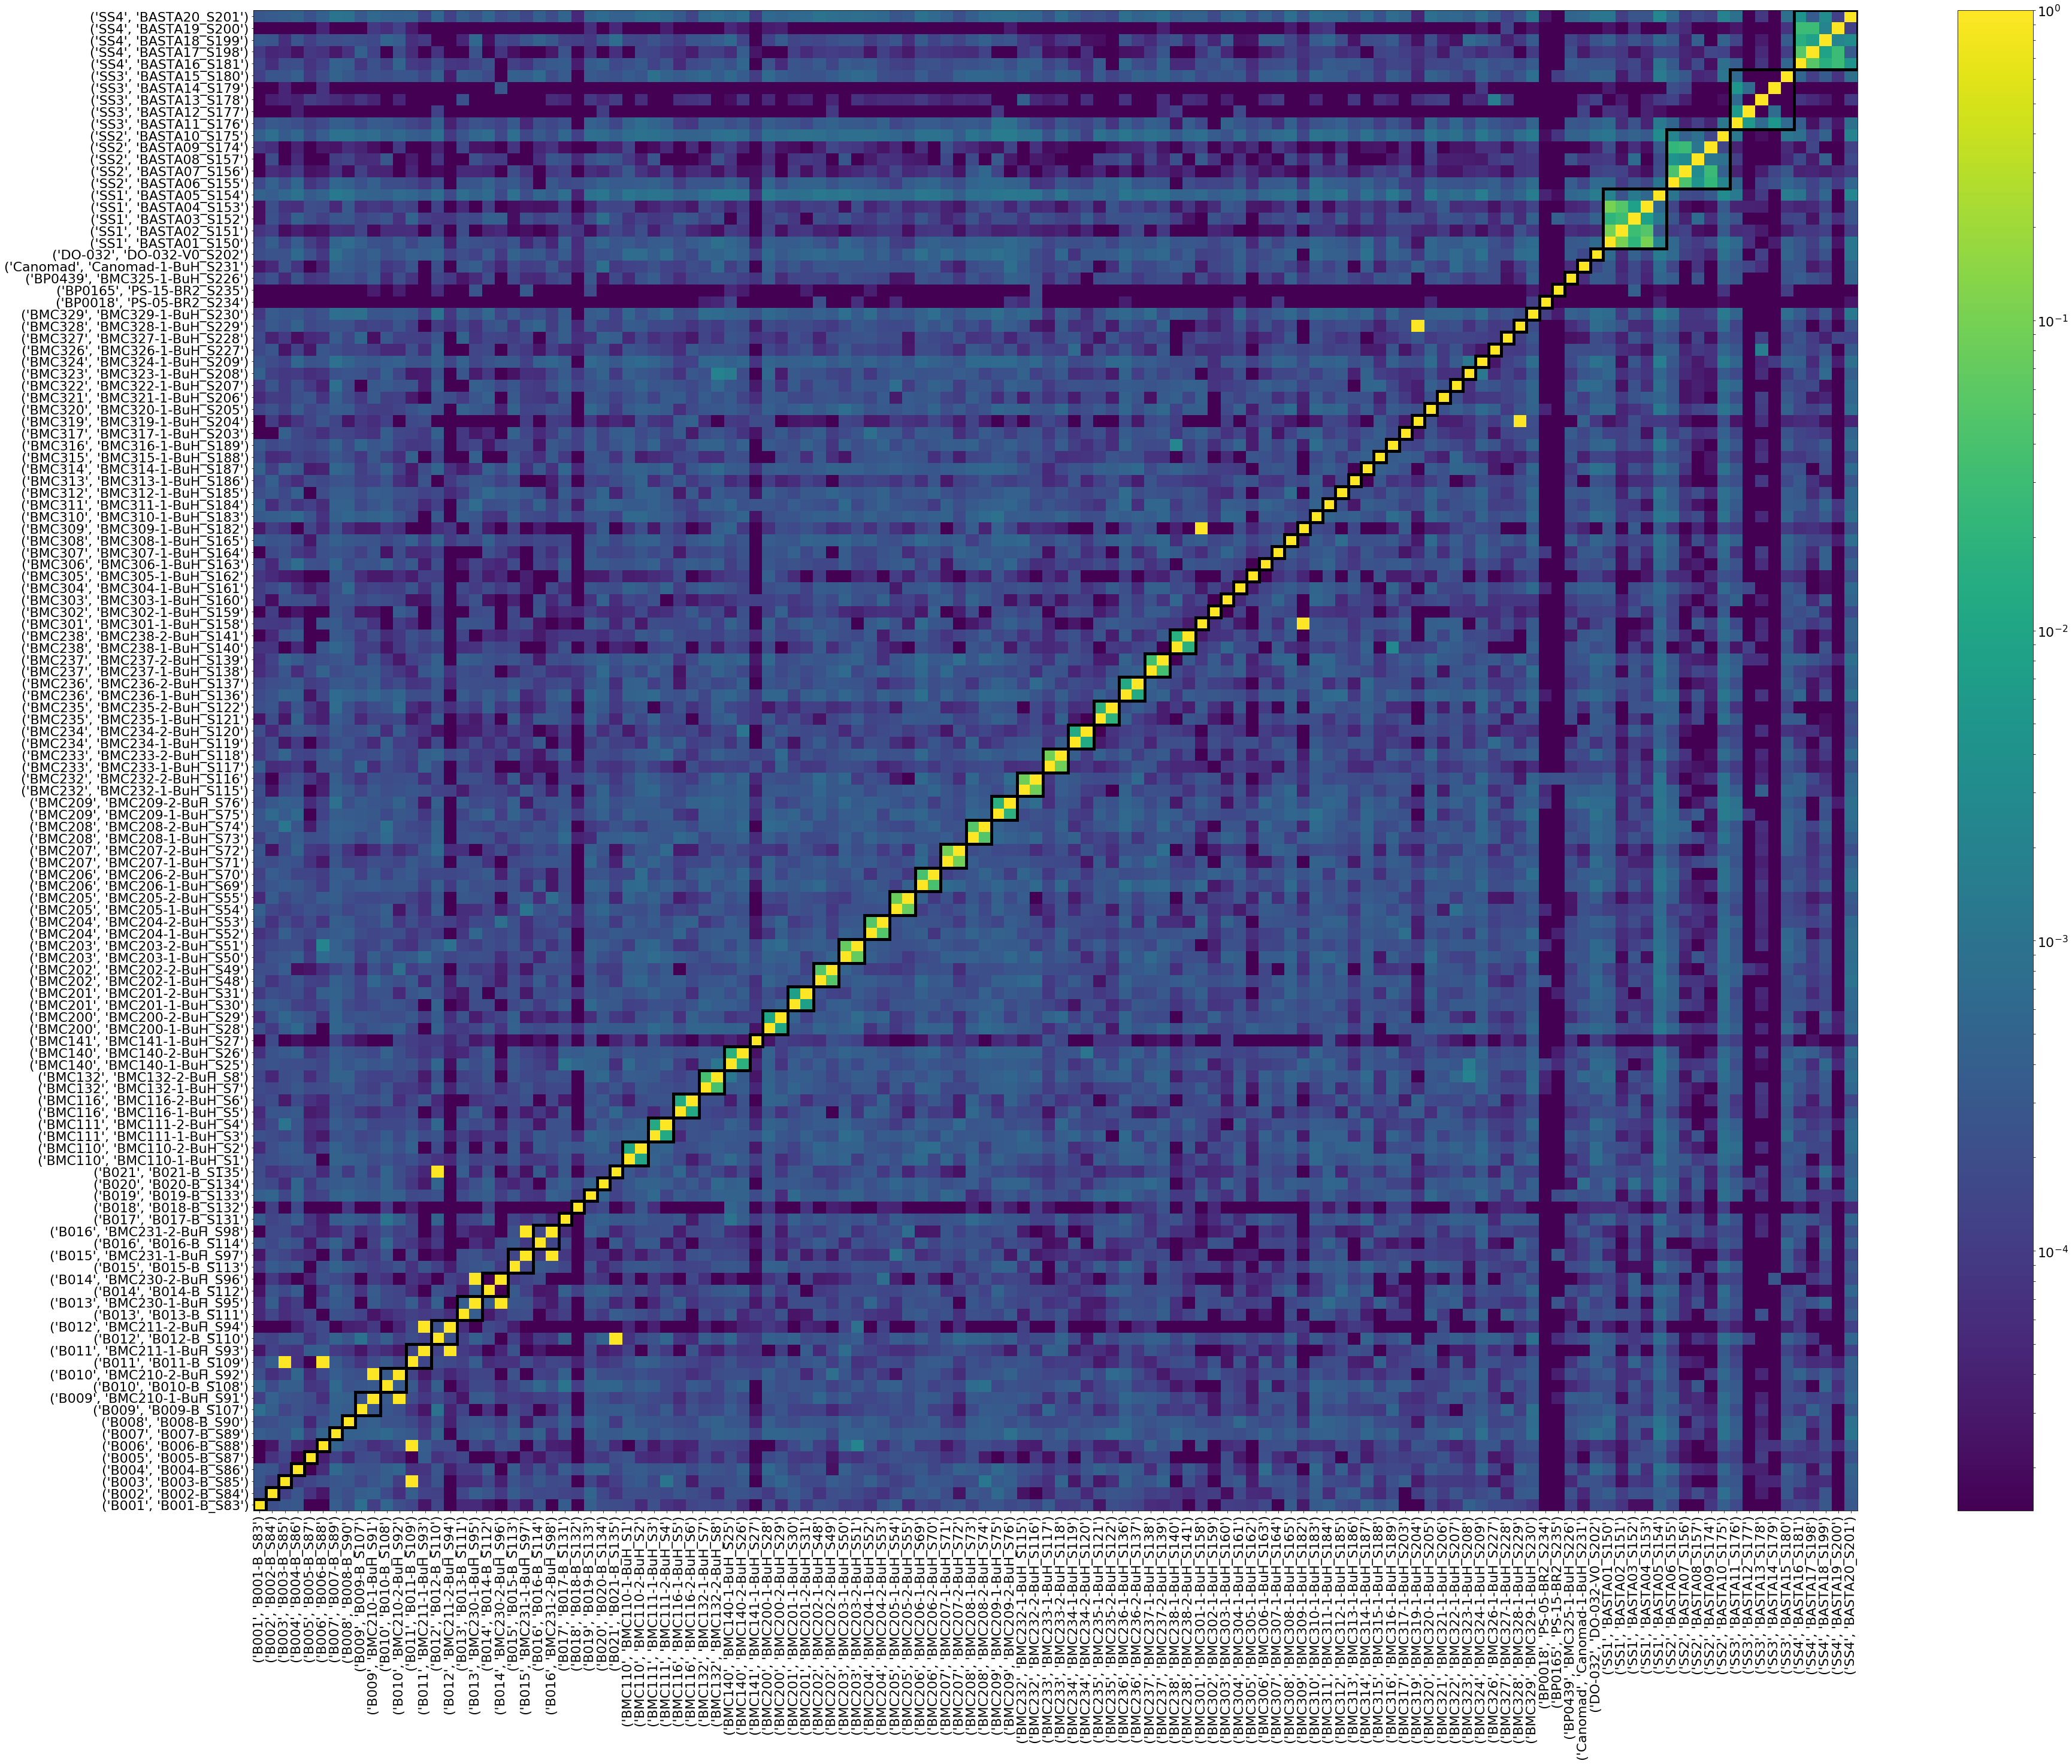

In [23]:
plotfile = plotfile.replace('.pdf', '-highlighted.pdf')
drawHeatmap(sim2)